In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

plt.style.use("default")


In [ ]:
trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)


(211224, 16)
(2644, 4)


In [ ]:
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    format="%d-%m-%Y %H:%M",
    errors="coerce"
)

trades["date"] = trades["Timestamp IST"].dt.date

trades = trades[
    (trades["Size USD"] > 0) &
    (trades["Execution Price"] > 0)
]

trades["is_long"] = trades["Direction"].str.lower().eq("buy").astype(int)

trades = trades[
    ["Trade ID", "Closed PnL", "Fee", "Size USD", "is_long", "date"]
]

trades.head()


,Trade ID,Closed PnL,Fee,Size USD,is_long,date
0,8.950000e+14,0.0,0.345404,7872.16,1,2024-12-02
1,4.430000e+14,0.0,0.005600,127.68,1,2024-12-02
2,6.600000e+14,0.0,0.050431,1150.63,1,2024-12-02
3,1.080000e+15,0.0,0.050043,1142.04,1,2024-12-02
4,1.050000e+15,0.0,0.003055,69.75,1,2024-12-02


In [ ]:
sentiment["timestamp"] = pd.to_datetime(sentiment["timestamp"], unit="s")
sentiment["date"] = sentiment["timestamp"].dt.date

sentiment["sentiment_regime"] = sentiment["classification"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
})

sentiment["sentiment_binary"] = (sentiment["sentiment_regime"] == "Greed").astype(int)

sentiment.head()


,timestamp,value,classification,date,sentiment_regime,sentiment_binary
0,2018-02-01 05:30:00,30,Fear,2018-02-01,Fear,0
1,2018-02-02 05:30:00,15,Extreme Fear,2018-02-02,Fear,0
2,2018-02-03 05:30:00,40,Fear,2018-02-03,Fear,0
3,2018-02-04 05:30:00,24,Extreme Fear,2018-02-04,Fear,0
4,2018-02-05 05:30:00,11,Extreme Fear,2018-02-05,Fear,0


In [ ]:
daily = (
    trades
    .groupby("date")
    .agg(
        total_trades=("Trade ID", "count"),
        total_pnl=("Closed PnL", "sum"),
        avg_pnl=("Closed PnL", "mean"),
        win_rate=("Closed PnL", lambda x: (x > 0).mean()),
        avg_fee=("Fee", "mean"),
        avg_trade_size_usd=("Size USD", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
    .merge(
        sentiment[["date", "sentiment_regime", "sentiment_binary"]],
        on="date",
        how="inner"
    )
    .dropna(subset=["sentiment_regime"])
)

daily.head()


,date,total_trades,total_pnl,avg_pnl,win_rate,avg_fee,avg_trade_size_usd,long_ratio,sentiment_regime,sentiment_binary
0,2023-05-01,3,0.000000,0.000000,0.000000,0.000000,159.000000,0.0,Greed,1
1,2023-12-05,9,0.000000,0.000000,0.000000,1.389051,5556.203333,0.0,Greed,1
2,2023-12-14,11,-205.434737,-18.675885,0.363636,2.572803,10291.213636,0.0,Greed,1
3,2023-12-15,2,-24.632034,-12.316017,0.000000,1.326245,5304.975000,0.0,Greed,1
4,2023-12-16,3,0.000000,0.000000,0.000000,1.279063,5116.256667,0.0,Greed,1


In [ ]:
import os
os.makedirs("csv_files", exist_ok=True)
daily.to_csv("csv_files/final_daily_dataset.csv", index=False)


In [ ]:
fear_pnl = daily.loc[daily["sentiment_regime"]=="Fear", "total_pnl"]
greed_pnl = daily.loc[daily["sentiment_regime"]=="Greed", "total_pnl"]

mannwhitneyu(fear_pnl, greed_pnl, alternative="two-sided")


MannwhitneyuResult(statistic=np.float64(17796.0), pvalue=np.float64(0.11085473589413827))

In [ ]:
mannwhitneyu(
    daily.loc[daily["sentiment_regime"]=="Fear", "avg_trade_size_usd"],
    daily.loc[daily["sentiment_regime"]=="Greed", "avg_trade_size_usd"]
)


MannwhitneyuResult(statistic=np.float64(15892.0), pvalue=np.float64(0.830846329597142))

<Figure size 640x480 with 0 Axes>

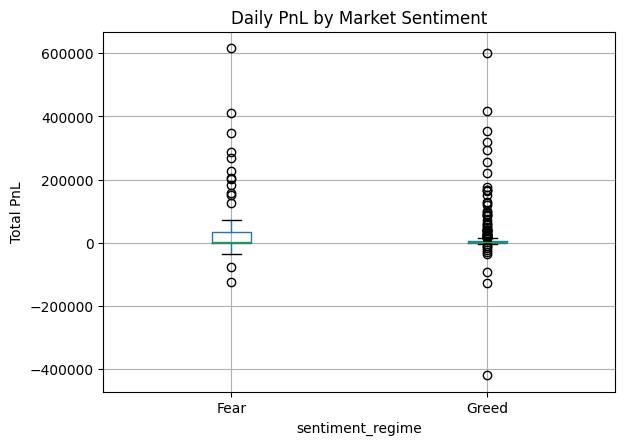

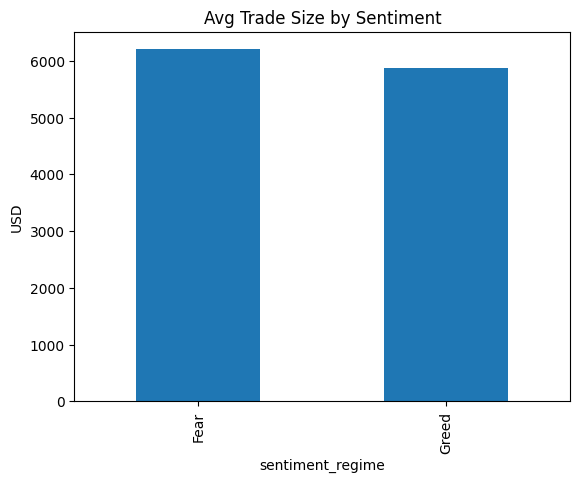

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

plot_df = daily[daily["sentiment_regime"].isin(["Fear", "Greed"])]

plt.figure()
plot_df.boxplot(column="total_pnl", by="sentiment_regime")
plt.title("Daily PnL by Market Sentiment")
plt.suptitle("")
plt.ylabel("Total PnL")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.show()
plt.close()

plt.figure()
plot_df.groupby("sentiment_regime")["avg_trade_size_usd"].mean().plot(
    kind="bar", title="Avg Trade Size by Sentiment"
)
plt.ylabel("USD")
plt.savefig("outputs/trade_size_by_sentiment.png")
plt.show()
plt.close()


In [ ]:
daily = daily[daily["sentiment_regime"].isin(["Fear", "Greed"])]

daily.groupby("sentiment_regime")[[
    "total_trades",
    "total_pnl",
    "avg_trade_size_usd",
    "long_ratio"
]].mean()


,total_trades,total_pnl,avg_trade_size_usd,long_ratio
sentiment_regime,,,,
Fear,792.628571,39012.054192,6200.667102,0.144405
Greed,294.016287,15847.884637,5873.954761,0.051502
